<a href="https://colab.research.google.com/github/SophiaHe/covid19_work/blob/master/Kalmar_Filter_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd
#url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url, error_bad_lines=False)
url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "Unites States")
death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "Unites States")
recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "Unites States")

In [0]:
population=pd.read_csv('https://raw.githubusercontent.com/SophiaHe/COVID19/master/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

# merge region
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)

def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)


ts=create_ts(confirmed)
ts_d=create_ts(death)
ts_rec=create_ts(recover)

# Create data for R script
ts_r=ts.reset_index()
ts_r=ts_r.rename(columns = {'index':'date'})
ts_r['date']=pd.to_datetime(ts_r['date'] ,errors ='coerce')
ts_r.to_csv(r'ts_r.csv')

In [0]:
regions = ['Canada_Alberta',
       'Canada_British Columbia', 'Canada_Grand Princess',
       'Canada_Manitoba', 'Canada_New Brunswick',
       'Canada_Newfoundland and Labrador', 'Canada_Northwest Territories',
       'Canada_Nova Scotia', 'Canada_Ontario',
       'Canada_Prince Edward Island', 'Canada_Quebec',
       'Canada_Saskatchewan']
confirmed[confirmed['region'].isin(regions)]

test

In [0]:
t=ts_d.head()
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']
print(temp)

Load back output from R code, conducting Kalmar filter method

In [0]:
p = pd.read_csv('pred_all.csv')

In [0]:
############ Merge R output due to package problem
t=ts_d
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

Update weather info

In [6]:
!pip install pyweatherbit
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 
#api_key = "26141d374d8e49d0a2e1f1254428ce8e"
#api_key ="f206579c74644c4b96a2423cb56a1687"
api_key ="81a581ac823849f38427fb5081cb8df8"
#api_key ="be7aaf4ff7184347aa1ebc2a2db514fe"

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.
##api.get_forecast(lat=lat, lon=lon)

  Created wheel for pyweatherbit: filename=pyweatherbit-2.0.0-cp36-none-any.whl size=6676 sha256=28df6c5bfd11659ebdfc5c43b58f9399935fce29681ced26a5c8e30dcc583908
  Stored in directory: /root/.cache/pip/wheels/d4/cb/bf/c00ca6550d58457b557cd1debb6a5c90c2880eee1c31da3b26
Successfully built pyweatherbit


In [0]:
w=pd.DataFrame(columns=['date','region','min','max'])
for i in range (61,len(confirmed)):
  start_date=pd.to_datetime('2020-01-22')
  for j in range (4,confirmed.shape[1]-2):
    jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date.strftime('%Y-%m-%d'),end_date=(start_date+ pd.DateOffset(days=1)).strftime('%Y-%m-%d')).json
    j=json_normalize(j)
    j=j['data']
    max_temp=json_normalize(j['data'])['max_temp'].values[0] # max
    min_temp=json_normalize(j['data'])['min_temp'].values[0]
    try:
      w=w.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
    except Exception:
      w=w.append({'date':confirmed.columns[j],'region':confirmed.iloc[i,confirmed.shape[1]-1] ,'min':None,'max':None}, ignore_index=True)
    start_date=start_date+ pd.DateOffset(days=1)

In [0]:
w=pd.read_csv('https://raw.githubusercontent.com/Rank23/COVID19/master/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')
#w['date']=pd.to_datetime(w['date'],errors ='coerce')

w_forecast=pd.read_csv('https://raw.githubusercontent.com/Rank23/COVID19/master/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

In [9]:
w.date.unique()

array(['2020-02-18T00:00:00.000000000', '2020-02-19T00:00:00.000000000',
       '2020-02-20T00:00:00.000000000', '2020-02-21T00:00:00.000000000',
       '2020-02-22T00:00:00.000000000', '2020-02-23T00:00:00.000000000',
       '2020-02-24T00:00:00.000000000', '2020-02-25T00:00:00.000000000',
       '2020-02-26T00:00:00.000000000', '2020-01-22T00:00:00.000000000',
       '2020-01-23T00:00:00.000000000', '2020-01-24T00:00:00.000000000',
       '2020-01-25T00:00:00.000000000', '2020-01-26T00:00:00.000000000',
       '2020-01-27T00:00:00.000000000', '2020-01-28T00:00:00.000000000',
       '2020-01-29T00:00:00.000000000', '2020-01-30T00:00:00.000000000',
       '2020-01-31T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-02-02T00:00:00.000000000', '2020-02-03T00:00:00.000000000',
       '2020-02-04T00:00:00.000000000', '2020-02-05T00:00:00.000000000',
       '2020-02-06T00:00:00.000000000', '2020-02-07T00:00:00.000000000',
       '2020-02-08T00:00:00.000000000', '2020-02-09

In [10]:
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is t.iloc[i-2,1]):
    t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
    t.iloc[i,6]=(t.iloc[i-1,2]/t.iloc[i-2,2]-1)*100
    t.iloc[i,9]=t.iloc[i-1,2]
  if(t.iloc[i,1] is t.iloc[i-4,1]):
    t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
    t.iloc[i,7]=(t.iloc[i-1,2]/t.iloc[i-4,2]-1)*100
  if(t.iloc[i,1] is t.iloc[i-8,1]):
    t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
    t.iloc[i,8]=(t.iloc[i-1,2]/t.iloc[i-8,2]-1)*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)
t['kalman_prediction']=round(t['kalman_prediction'])
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(1)
train['population']=train['population'].astype('int32')
train['infected_rate'] =train['last_day']/train['population']*10000
train=train.merge(w,how='left',on=['date','region'])
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
  if(np.isnan(train.iloc[i,13])):
    if(train.iloc[i,1] is train.iloc[i-1,1]):
      train.iloc[i,13]=train.iloc[i-1,13]
      train.iloc[i,14]=train.iloc[i-1,14]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in long_scalars


In [11]:
t.region.unique()

array(['Afghanistan_nan', 'Albania_nan', 'Algeria_nan', 'Andorra_nan',
       'Angola_nan', 'Antigua and Barbuda_nan', 'Argentina_nan',
       'Armenia_nan', 'Australia_Australian Capital Territory',
       'Australia_New South Wales', 'Australia_Northern Territory',
       'Australia_Queensland', 'Australia_South Australia',
       'Australia_Tasmania', 'Australia_Victoria',
       'Australia_Western Australia', 'Austria_nan', 'Azerbaijan_nan',
       'Bahamas_nan', 'Bahrain_nan', 'Bangladesh_nan', 'Barbados_nan',
       'Belarus_nan', 'Belgium_nan', 'Belize_nan', 'Benin_nan',
       'Bhutan_nan', 'Bolivia_nan', 'Bosnia and Herzegovina_nan',
       'Botswana_nan', 'Brazil_nan', 'Brunei_nan', 'Bulgaria_nan',
       'Burkina Faso_nan', 'Burma_nan', 'Burundi_nan', 'Cabo Verde_nan',
       'Cambodia_nan', 'Cameroon_nan', 'Canada_Alberta',
       'Canada_British Columbia', 'Canada_Diamond Princess',
       'Canada_Grand Princess', 'Canada_Manitoba', 'Canada_New Brunswick',
       'Canada_N

Kalman 1 day Prediction with Evaluation

                region           mse          rmse          mae
248  Unites States_nan  6.006373e+08  24507.902209  4856.014286
                       region  confirmed  kalman_prediction
date                                                       
2020-03-28  Unites States_nan   121478.0           107282.0
2020-03-29  Unites States_nan   140886.0           129150.0
2020-03-30  Unites States_nan   161807.0           151594.0
2020-03-31  Unites States_nan   188172.0           174830.0
2020-04-01  Unites States_nan        NaN           201502.0


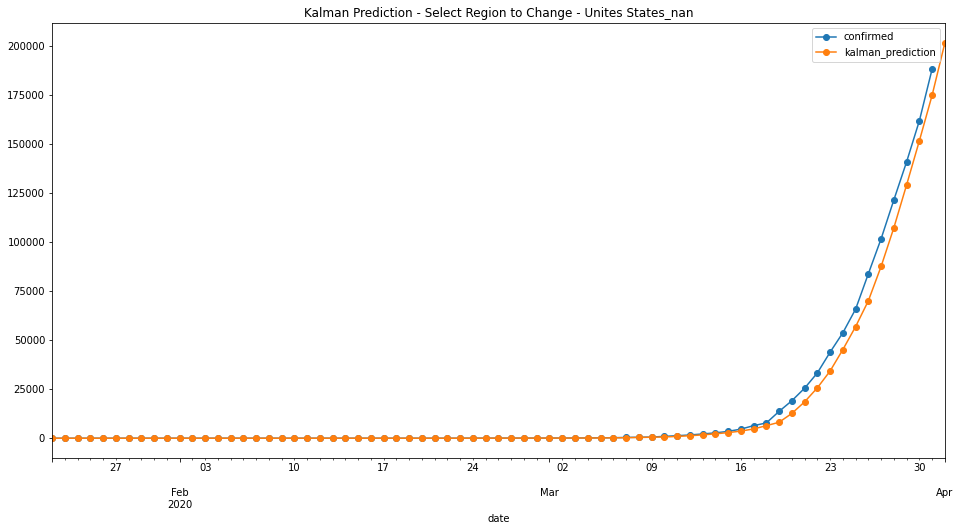

In [13]:
# Select region
region='Unites States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])
print(p.tail())


            region      mse        rmse        mae
48  Canada_Ontario  64055.0  253.090893  51.028571
                    region  confirmed  kalman_prediction
date                                                    
2020-03-28  Canada_Ontario     1144.0             1042.0
2020-03-29  Canada_Ontario     1355.0             1214.0
2020-03-30  Canada_Ontario     1706.0             1425.0
2020-03-31  Canada_Ontario     1966.0             1743.0
2020-04-01  Canada_Ontario        NaN             2067.0


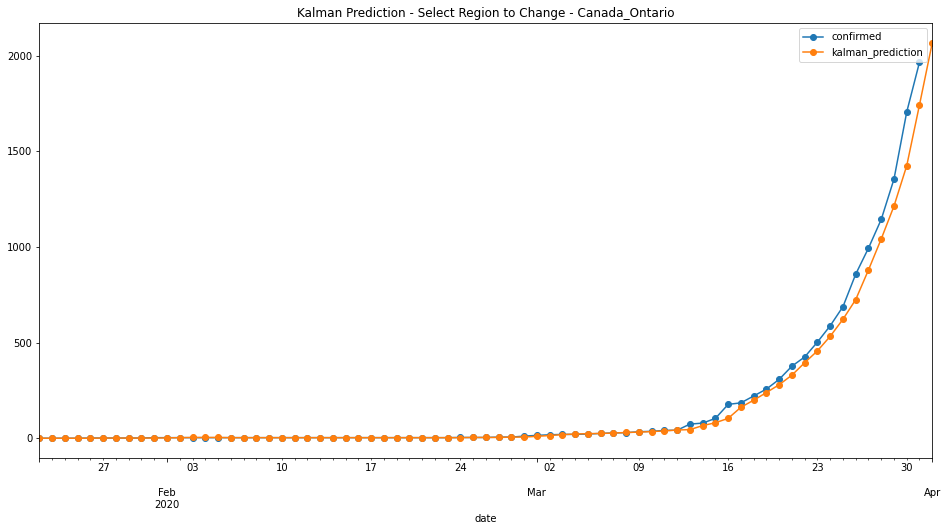

In [14]:
# Select region
region='Canada_Ontario'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])
print(p.tail())

           region       mse        rmse         mae
50  Canada_Quebec  294351.7  542.541888  110.442857
            date        region  ...  last_day  kalman_prediction
18171 2020-03-28  Zimbabwe_nan  ...         5                5.0
18172 2020-03-29  Zimbabwe_nan  ...         7                7.0
18173 2020-03-30  Zimbabwe_nan  ...         7                8.0
18174 2020-03-31  Zimbabwe_nan  ...         7                8.0
18175 2020-04-01  Zimbabwe_nan  ...         8                9.0

[5 rows x 11 columns]
                   region  confirmed  kalman_prediction
date                                                   
2020-03-28  Canada_Quebec     2498.0             2187.0
2020-03-29  Canada_Quebec     2840.0             2690.0
2020-03-30  Canada_Quebec     3430.0             3139.0
2020-03-31  Canada_Quebec     4162.0             3698.0
2020-04-01  Canada_Quebec        NaN             4406.0


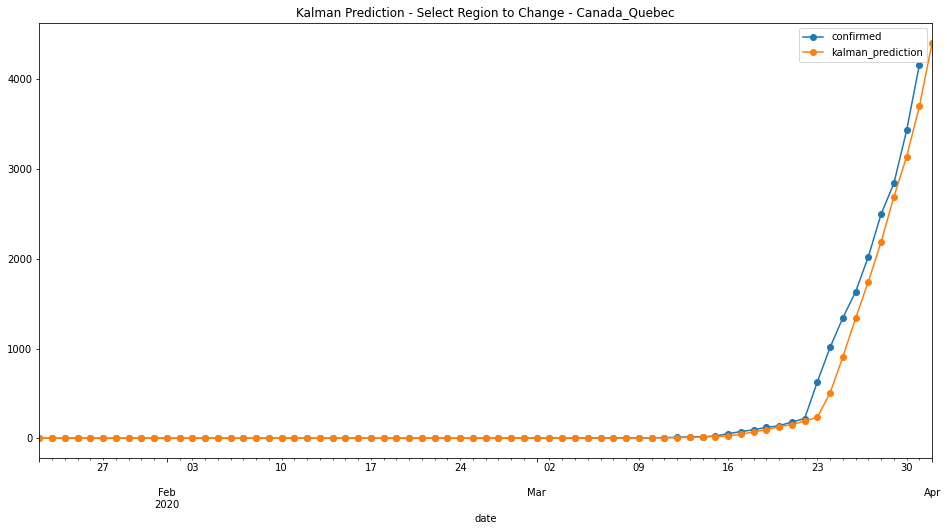

In [15]:
# Select region
region='Canada_Quebec'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])
print(p.tail())

                     region           mse        rmse        mae
40  Canada_British Columbia  17646.542857  132.840291  26.285714
                             region  confirmed  kalman_prediction
date                                                             
2020-03-28  Canada_British Columbia      884.0              819.0
2020-03-29  Canada_British Columbia      884.0              922.0
2020-03-30  Canada_British Columbia      970.0              971.0
2020-03-31  Canada_British Columbia     1013.0             1037.0
2020-04-01  Canada_British Columbia        NaN             1089.0


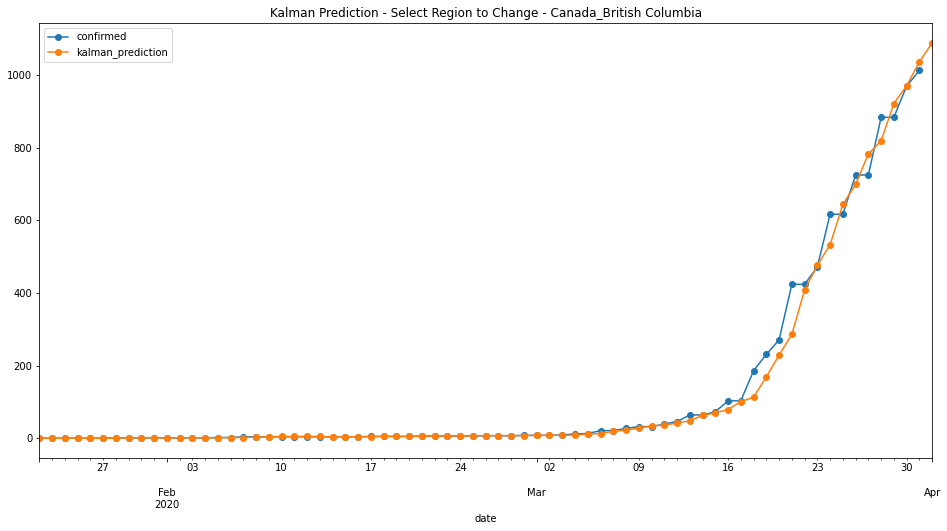

In [16]:
# Select region
region='Canada_British Columbia'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])
print(p.tail())

**Prepare data for ML models**

Linear Regression Model

In [0]:
!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='8G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.6" 2020-01-14; OpenJDK Runtime Environment (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1); OpenJDK 64-Bit Server VM (build 11.0.6+10-post-Ubuntu-1ubuntu118.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3mpc63yx
  JVM stdout: /tmp/tmp3mpc63yx/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp3mpc63yx/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,6 days
H2O cluster name:,H2O_from_python_unknownUser_sa2es2
H2O cluster total nodes:,1
H2O cluster free memory:,8 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [0]:
# Train: < 0317
# Test: >= 0317 & < 0320
train_limit = '2020-03-19'
recent_limit = '2020-03-16'
test_lr = '2020-03-19'
test_up = '2020-03-22'

train=train.fillna(0) 
train_df=train[train['date']< train_limit]
# boots=train_df[train_df['date']>= recent_limit] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>= recent_limit]]*1000,ignore_index=True)
train_df_hubei=train_df[train_df['region']=='China_Hubei']
test=train[train['date']>= test_lr]
test=test[test['date']< test_up]

train_df.tail()

,date,region,confirmed,1_day_change,3_day_change,7_day_change,1_day_change_rate,3_day_change_rate,7_day_change_rate,last_day,kalman_prediction,population,infected_rate,min,max
30417,2020-03-14,Zimbabwe_nan,0,0,0,0,0.0,0.0,0.0,0,0.0,1,0.0,0.0,0.0
30418,2020-03-15,Zimbabwe_nan,0,0,0,0,0.0,0.0,0.0,0,0.0,1,0.0,0.0,0.0
30419,2020-03-16,Zimbabwe_nan,0,0,0,0,0.0,0.0,0.0,0,0.0,1,0.0,0.0,0.0
30420,2020-03-17,Zimbabwe_nan,0,0,0,0,0.0,0.0,0.0,0,0.0,1,0.0,0.0,0.0
30421,2020-03-18,Zimbabwe_nan,0,0,0,0,0.0,0.0,0.0,0,0.0,1,0.0,0.0,0.0


In [0]:
# Train LR model
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            'last_day', 'kalman_prediction','infected_rate', 'min', 'max'
          ]
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col])
pred2=pd.DataFrame(columns = ["prediction"], data = pred2);
pred2.prediction=pred2.prediction.round(0);
pred2['confirmed']=test['confirmed'].values; 
pred2['date']=test['date'].values; 
pred2['region']=test['region'].values
pred2.head()



,prediction,confirmed,date,region
0,18.0,22,2020-03-19,Afghanistan_nan
1,18.0,24,2020-03-20,Afghanistan_nan
2,21.0,24,2020-03-21,Afghanistan_nan
3,71.0,64,2020-03-19,Albania_nan
4,73.0,70,2020-03-20,Albania_nan


In [0]:
# Select region
selection_region = ["Canada_Ontario", 'Canada_Alberta', 'Canada_British Columbia',
       'Canada_Grand Princess', 'Canada_Manitoba', 'Canada_New Brunswick',
       'Canada_Newfoundland and Labrador', 'Canada_Nova Scotia',
       'Canada_Prince Edward Island', 'Canada_Quebec','Canada_Saskatchewan']


pred2['se'] = np.power((pred2['confirmed'] - pred2['prediction']),2)
#pred2.loc[pred2['region'].isin(selection_region)].groupby(['region','date'], as_index=False)['se'].mean()
#pred2.head()

In [0]:
region='Canada_Ontario'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])

place=0
for i in range(1,len(t)):
  if(t.iloc[i,1] is not t.iloc[i-1,1]):
    ex=np.array(t.iloc[i-len(ts):i,10])
    pred=np.array(t.iloc[i-len(ts):i,2])
    evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
# p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))
print(evaluation[evaluation['region']==p.iloc[0,0]])
print(t.tail())
print(p.tail())

In [0]:
regions = ["Canada_Ontario", 'Canada_Alberta', 'Canada_British Columbia',
       'Canada_Grand Princess', 'Canada_Manitoba', 'Canada_New Brunswick',
       'Canada_Newfoundland and Labrador', 'Canada_Nova Scotia',
       'Canada_Prince Edward Island', 'Canada_Quebec','Canada_Saskatchewan']
can_train = train_df[train_df['region'].isin(regions)]
print(train_df)

            date           region  confirmed  ...  infected_rate  min  max
0     2020-01-22  Afghanistan_nan          0  ...            0.0  0.0  0.0
1     2020-01-23  Afghanistan_nan          0  ...            0.0  0.0  0.0
2     2020-01-24  Afghanistan_nan          0  ...            0.0  0.0  0.0
3     2020-01-25  Afghanistan_nan          0  ...            0.0  0.0  0.0
4     2020-01-26  Afghanistan_nan          0  ...            0.0  0.0  0.0
...          ...              ...        ...  ...            ...  ...  ...
30417 2020-03-14     Zimbabwe_nan          0  ...            0.0  0.0  0.0
30418 2020-03-15     Zimbabwe_nan          0  ...            0.0  0.0  0.0
30419 2020-03-16     Zimbabwe_nan          0  ...            0.0  0.0  0.0
30420 2020-03-17     Zimbabwe_nan          0  ...            0.0  0.0  0.0
30421 2020-03-18     Zimbabwe_nan          0  ...            0.0  0.0  0.0

[27992 rows x 15 columns]


In [0]:
# Train ML model
#can_train = train_df[regions]
x_col=['1_day_change', '3_day_change','7_day_change','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
x=train_df[x_col]
y=train_df['confirmed']
# reg = LinearRegression().fit(x,y)

# GBM
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
p_test3 = {'learning_rate':[0.15,0.1]}
# max_depth':[2,3,4,5,6,7], 'min_samples_split':[2,4,6,8,10,20,40,60,100], 'min_samples_leaf':[1,3,5,7,9],'max_features':[2,3,4,5,6,7], 'subsample':[0.7,0.75,0.8,0.85,0.9,0.95,1]
# min_samples_split: sets the minimum number of samples to split,
# min_samples_leaf: sets the minimum number of samples to form a leaf
tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, 
                                                            subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=1,iid=False, cv=5)
tuning.fit(x,y)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

#calculate values for ROC AUC plot
#baseline model
#baseline_roc_auc = roc_auc_score(y_test, baseline.predict(X_test))
#fprB, tprB, thresholdsB = roc_curve(y_test, baseline.predict_proba(X_test)[:,1])




/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


KeyboardInterrupt: ignored

In [0]:
pred2=reg.predict(test[x_col])
pred2=pd.DataFrame(columns = ["prediction"], data = pred2);
pred2.prediction=pred2.prediction.round(0);
pred2['confirmed']=test['confirmed'].values; 
pred2['date']=test['date'].values; 
pred2['region']=test['region'].values
pred2.head()

# **long term prediction model**

In [0]:
# 30 days from the latest date: april 18 is 30 days after march 19
all_new = pd.read_csv("all_new.csv")

all_new['date']=pd.to_datetime(all_new['date'])
all_new.tail()

,Unnamed: 0,date,Afghanistan_nan,Albania_nan,Algeria_nan,Andorra_nan,Angola_nan,Antigua and Barbuda_nan,Argentina_nan,Armenia_nan,Australia_Australian Capital Territory,Australia_From Diamond Princess,Australia_New South Wales,Australia_Northern Territory,Australia_Queensland,Australia_South Australia,Australia_Tasmania,Australia_Victoria,Australia_Western Australia,Austria_nan,Azerbaijan_nan,"Bahamas, The_nan",Bahrain_nan,Bangladesh_nan,Barbados_nan,Belarus_nan,Belgium_nan,Benin_nan,Bhutan_nan,Bolivia_nan,Bosnia and Herzegovina_nan,Brazil_nan,Brunei_nan,Bulgaria_nan,Burkina Faso_nan,Cabo Verde_nan,Cambodia_nan,Cameroon_nan,Canada_Alberta,Canada_British Columbia,...,"Unites States_Suffolk County, NY","Unites States_Sullivan, TN","Unites States_Summit County, CO","Unites States_Summit, UT","Unites States_Tarrant, TX",Unites States_Tennessee,Unites States_Texas,"Unites States_Thurston, WA","Unites States_Tulsa County, OK","Unites States_Ulster County, NY","Unites States_Umatilla, OR","Unites States_Union, NJ",Unites States_Utah,"Unites States_Ventura, CA",Unites States_Vermont,Unites States_Virgin Islands,Unites States_Virginia,"Unites States_Volusia County, FL","Unites States_Wake County, NC",Unites States_Washington,"Unites States_Washington County, OR","Unites States_Washington, D.C.","Unites States_Washoe County, NV","Unites States_Wayne County, PA","Unites States_Wayne, MI","Unites States_Weber, UT",Unites States_West Virginia,"Unites States_Westchester County, NY","Unites States_Whatcom, WA","Unites States_Williamson County, TN",Unites States_Wisconsin,"Unites States_Worcester, MA",Unites States_Wyoming,"Unites States_Yolo County, CA",Uruguay_nan,Uzbekistan_nan,Venezuela_nan,Vietnam_nan,Zambia_nan,Zimbabwe_nan
86,87,2020-04-17,68,149,725,258,4,1,397,489,65,0,1380,3,413,225,41,730,271,6197,129,15,426,82,49,202,7977,2,2,46,379,4810,142,485,169,9,432,104,722,1239,...,0,0,0,0,0,1556,2132,0,0,0,0,0,588,0,158,9,590,0,0,4260,0,0,0,0,0,0,43,2,0,0,1488,0,67,0,304,106,190,296,4,6
87,88,2020-04-18,68,150,725,277,4,1,397,489,68,0,1380,3,413,225,41,730,272,6368,136,15,426,82,50,206,8364,2,2,48,379,4810,142,501,169,9,437,104,722,1239,...,0,0,0,0,0,1598,2132,0,0,0,0,0,608,0,168,9,590,0,0,4260,0,0,0,0,0,0,43,2,0,0,1488,0,67,0,305,106,190,307,4,6
88,89,2020-04-19,72,150,725,284,4,1,397,529,68,0,1380,3,413,225,41,730,272,6494,136,15,426,82,50,206,8364,2,2,48,379,5094,142,503,176,9,437,104,722,1239,...,0,0,0,0,0,1598,2132,0,0,0,0,0,610,0,169,9,590,0,0,4260,0,0,0,0,0,0,43,2,0,0,1595,0,71,0,305,106,199,307,4,6
89,90,2020-04-20,73,150,725,285,4,1,397,556,68,0,1380,3,413,225,41,730,272,6758,136,15,434,82,52,206,8364,2,2,48,379,5094,149,515,176,9,459,104,755,1239,...,0,0,0,0,0,1634,2132,0,0,0,0,0,610,0,169,9,608,0,0,4563,0,0,0,0,0,0,43,2,0,0,1595,0,71,0,305,106,199,325,4,6
90,91,2020-04-21,77,150,782,285,4,1,406,556,68,0,1414,3,413,239,41,730,275,6758,136,16,437,90,55,219,8364,2,2,48,397,5094,149,515,180,9,459,104,755,1267,...,0,0,0,0,0,1634,2144,0,0,0,0,0,646,0,169,9,608,0,0,4563,0,0,0,0,0,0,43,2,0,0,1668,0,71,0,323,106,199,328,4,6


            Canada_Ontario
date                      
2020-03-22             425
2020-03-23             451
2020-03-24             501
2020-03-25             553
2020-03-26             613
2020-03-27             629
2020-03-28             629
2020-03-29             726
2020-03-30             787
2020-03-31             787
2020-04-01             879
2020-04-02             892
2020-04-03             991
2020-04-04             991
2020-04-05             991
2020-04-06            1099
2020-04-07            1160
2020-04-08            1160
2020-04-09            1166
2020-04-10            1251
2020-04-11            1251
2020-04-12            1251
2020-04-13            1362
2020-04-14            1415
2020-04-15            1465
2020-04-16            1465
2020-04-17            1465
2020-04-18            1465
2020-04-19            1592
2020-04-20            1592
2020-04-21            1666


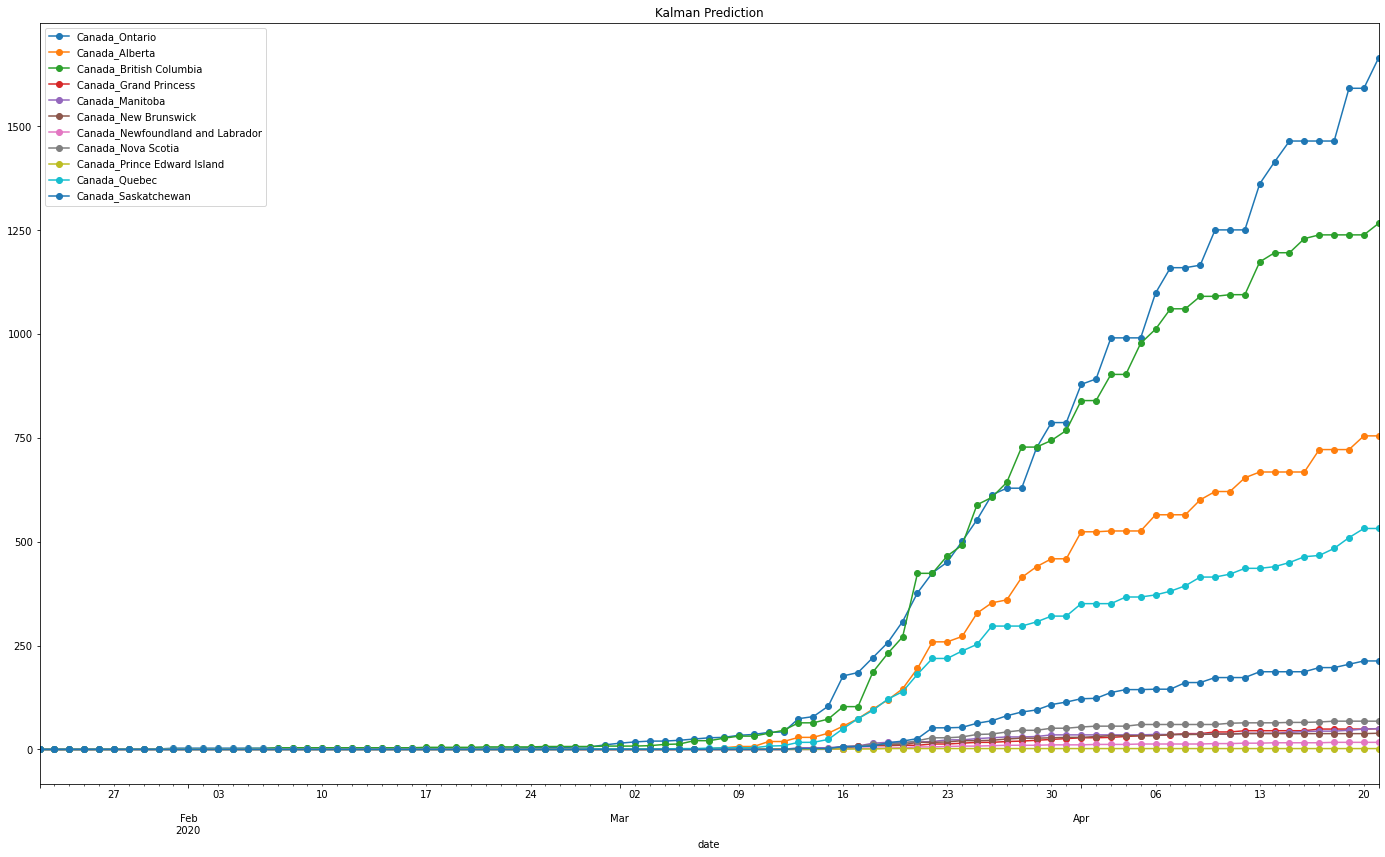

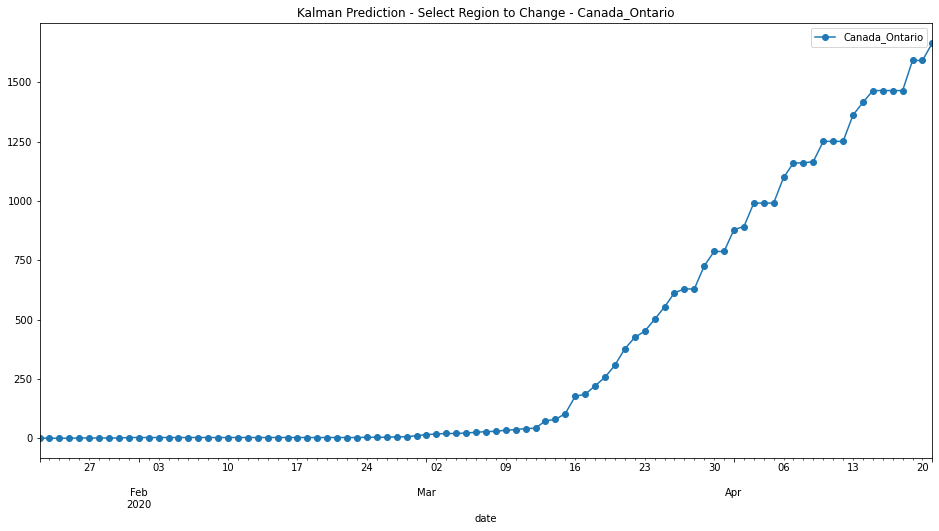

In [0]:
# Select region
region=['date',"Canada_Ontario", 'Canada_Alberta', 'Canada_British Columbia',
       'Canada_Grand Princess', 'Canada_Manitoba', 'Canada_New Brunswick',
       'Canada_Newfoundland and Labrador', 'Canada_Nova Scotia',
       'Canada_Prince Edward Island', 'Canada_Quebec','Canada_Saskatchewan']
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')

p_kalman2=all_new[['date','Canada_Ontario']]
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p_kalman2.columns[0]))
print(p_kalman2.tail(n= 31))

            Korea, South_nan
date                        
2020-03-22              8897
2020-03-23              9368
2020-03-24              9368
2020-03-25              9368
2020-03-26              9368
2020-03-27              9368
2020-03-28             10049
2020-03-29             10049
2020-03-30             10049
2020-03-31             10049
2020-04-01             10578
2020-04-02             10578
2020-04-03             10578
2020-04-04             10578
2020-04-05             10578
2020-04-06             11237
2020-04-07             11300
2020-04-08             11300
2020-04-09             11300
2020-04-10             12077
2020-04-11             12077
2020-04-12             12077
2020-04-13             12310
2020-04-14             12310
2020-04-15             12310
2020-04-16             12310
2020-04-17             12310
2020-04-18             12310
2020-04-19             12422
2020-04-20             12422
2020-04-21             12422


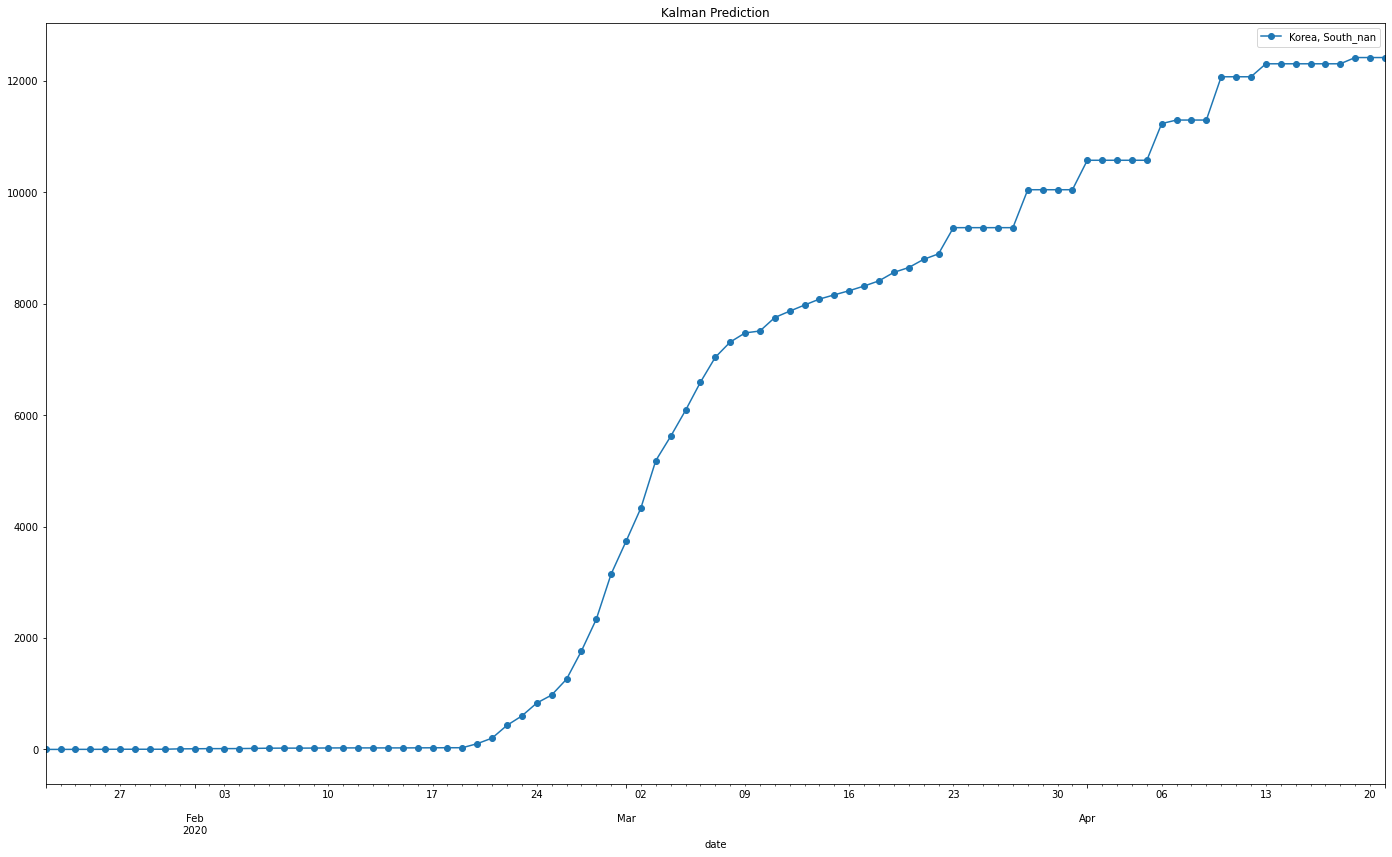

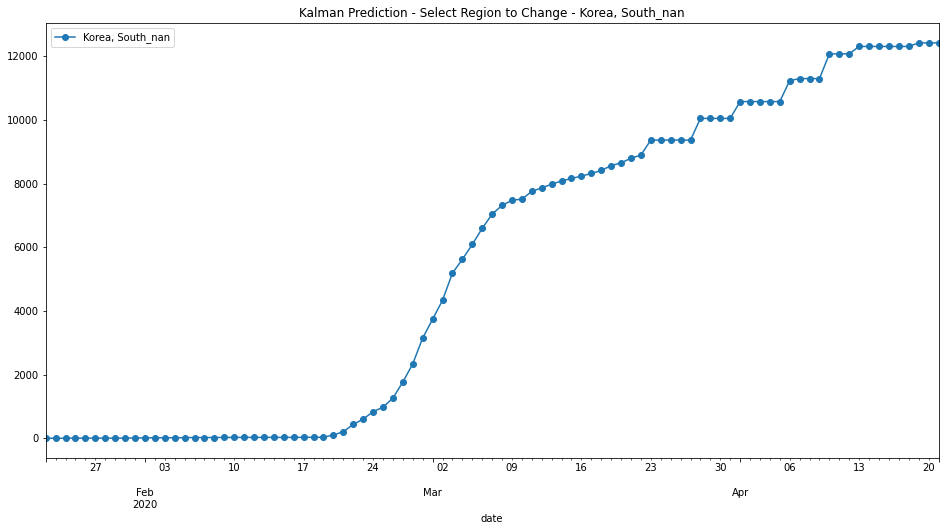

In [0]:
# Select region
region=['date',"Korea, South_nan"]
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')

p_kalman2=all_new[['date','Korea, South_nan']]
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p_kalman2.columns[0]))
print(p_kalman2.tail(n= 31))



Iterative Regression

In [0]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
  if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
    t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
  if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
    t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
    t_iter.iloc[i,6]=(t_iter.iloc[i-1,2]/t_iter.iloc[i-2,2]-1)*100
    t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
  if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
    t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
    t_iter.iloc[i,7]=(t_iter.iloc[i-1,2]/t_iter.iloc[i-4,2]-1)*100
  if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
    t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
    t_iter.iloc[i,8]=(t_iter.iloc[i-1,2]/t_iter.iloc[i-8,2]-1)*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])
test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(1)
test_iter['population']=test_iter['population'].astype('int32')
test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])
test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
  if(np.isnan(test_iter.iloc[i,13])):
    if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
      test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
      test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in long_scalars


In [0]:
# Train LR model
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            'last_day', 'kalman_prediction','infected_rate', 'min', 'max'
          ]
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col])
pred2=pd.DataFrame(columns = ["prediction"], data = pred2);
pred2.prediction=pred2.prediction.round(0);
pred2['confirmed']=test['confirmed'].values; 
pred2['date']=test['date'].values; 
pred2['region']=test['region'].values
pred2.head()

In [0]:
test_iter.head()

,date,region,confirmed,1_day_change,3_day_change,7_day_change,1_day_change_rate,3_day_change_rate,7_day_change_rate,last_day,kalman_prediction,population,infected_rate,min,max
0,2020-01-22,Afghanistan_nan,0,0,0,0,0.0,0.0,0.0,0,0,35530000,0.0,0.0,0.0
1,2020-01-23,Afghanistan_nan,0,0,0,0,0.0,0.0,0.0,0,0,35530000,0.0,0.0,0.0
2,2020-01-24,Afghanistan_nan,0,0,0,0,0.0,0.0,0.0,0,0,35530000,0.0,0.0,0.0
3,2020-01-25,Afghanistan_nan,0,0,0,0,0.0,0.0,0.0,0,0,35530000,0.0,0.0,0.0
4,2020-01-26,Afghanistan_nan,0,0,0,0,0.0,0.0,0.0,0,0,35530000,0.0,0.0,0.0


In [0]:
test_iter=test_iter.fillna(0) 

x_col=['1_day_change', '3_day_change','7_day_change','last_day', 'kalman_prediction','infected_rate', 'min', 'max']

x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values
for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
      if(pred.iloc[i,0]<pred.iloc[i-1,1]):
        pred.iloc[i,0]=pred.iloc[i-1,1]

#pred=pred.reset_index().pivot(index='date',columns='region',values='prediction')
region=["Canada_Ontario", 'Canada_Alberta', 'Canada_British Columbia',
       'Canada_Grand Princess', 'Canada_Manitoba', 'Canada_New Brunswick',
       'Canada_Newfoundland and Labrador', 'Canada_Nova Scotia',
       'Canada_Prince Edward Island', 'Canada_Quebec','Canada_Saskatchewan'] 

pred = pred.drop_duplicates(subset=['date','region'], keep="last")
#pred = pred[pred['region'] == 'Canada_British Columbia']
pred = pred.pivot(index='date',columns='region',values='prediction')
#print(len(pred))
#print(pred.head())
#a = pred.groupby(['date', 'region']).size().to_frame(name = 'size').reset_index()
#print(a.loc[a['size'] > 1])
#pandas.set_option('display.max_rows', pred.shape[0]+1)
#pred.loc[pred['region'] == 'Canada_British Columbia' & pred['date'] == '2020-02-18']
#pred[pred['region'] == 'Canada_British Columbia']

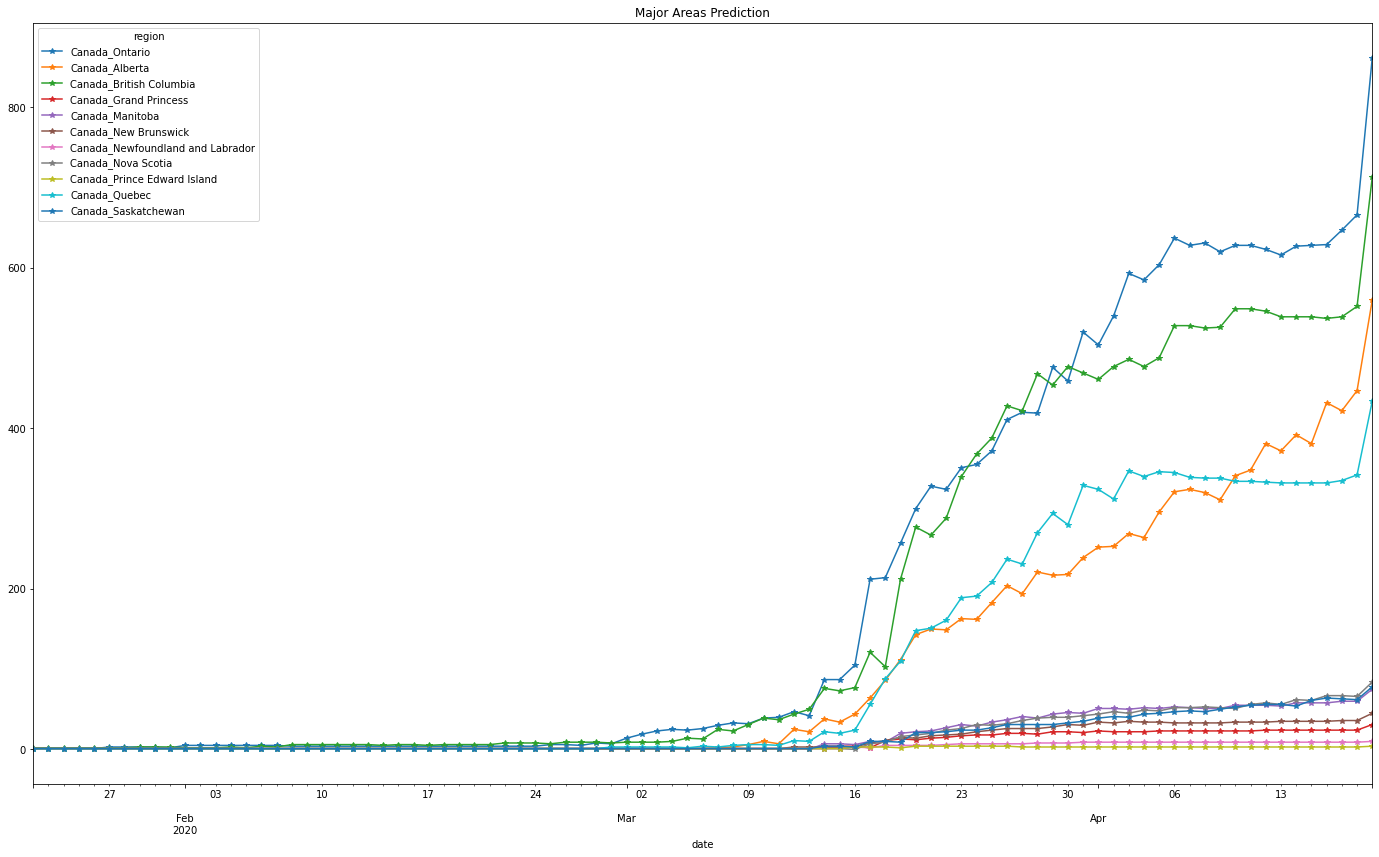

In [0]:
select_region=["Canada_Ontario", 'Canada_Alberta', 'Canada_British Columbia',
       'Canada_Grand Princess', 'Canada_Manitoba', 'Canada_New Brunswick',
       'Canada_Newfoundland and Labrador', 'Canada_Nova Scotia',
       'Canada_Prince Edward Island', 'Canada_Quebec','Canada_Saskatchewan']      

p=pred[select_region]
p.plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

p.tail(n=33)
p.to_csv(r'long_term_pred_0319.csv')


In [0]:
print(pred['date'].value_counts())

2020-02-26    532
2020-02-25    532
2020-02-29    527
2020-03-01    527
2020-02-28    527
             ... 
2020-03-18    469
2020-03-05    469
2020-02-08    469
2020-01-26    469
2020-03-27    469
Name: date, Length: 89, dtype: int64
